# MC Slowing Down using OpenMC Data

This noteboook provides a Monte Carlo slowing down process.  It does take a few shortcuts, so please use carefully.

In [1]:
%matplotlib inline

import openmc
import numpy as np
import matplotlib.pyplot as plt
import random
import math

Read the OpenMC U-238 data library, specifically the absorption and scattering cross-sections.

In [2]:
u238 = openmc.data.IncidentNeutron.from_hdf5('U238.h5')

In [3]:
abso = u238[102]
scat = u238[2]

In [4]:
A_h = 1
alpha_h = 0
A_U = 238
alpha_U = 237**2/239**2
h_xs = 20   #Approximate 20 barns H-1 scattering cross-section
I_xs = 6    #Approximate 6 barns O-16 scattering cross-section
A_I = 16
alpha_I = (A_I-1)**2/(A_I+1)**2
print(alpha_I)

0.7785467128027682


In [5]:
energies = np.linspace(1,7000,1000000)  #this code only looks at the flux below 7000 eV
delta_e = energies[1]-energies[0]

In [6]:
energies[9999]

70.98307098307099

Here we define that our problem contains H-1 and U-238, we compute the $\alpha$ values, assign the nuclide densities and then calculates the dilution cross section.  For calculating the IR parameter, we will assume that the hydrogen cross section is flat and exactly 20b, but we will use the real U-238 cross-section.  We will caculate effective resonance integrals over 3 groups encompassing the three low-energy resonances.

In [7]:
def MC_slowing_down(N_h,N_u,N_I,Estart,nps):
    random.seed(a=2)
    abs_counter = np.zeros(5)
    flux_counter = np.zeros(len(energies))
    total_flux = 0
    for i in range(nps):
        E = Estart
        while (E>1.0):
            #Calculate Sigma_t, the next two lines read the abs and scat xs of U-238 at energy E, 
            #linear interpolation is performed automatically between the nearest values in the library.
            u238_abs = abso.xs['294K'](E)
            u238_scat = scat.xs['294K'](E)
            sigt_u238 = u238_abs + u238_scat
            if E>6000.0:   #this code neglects absorption above 6000 eV
                Sigma_t = N_h*h_xs + N_I*I_xs
            else:
                Sigma_t = N_h*h_xs + N_u*sigt_u238 + N_I*I_xs
            if E<7000.0:  #flux is only tallied below 7000 eV
                index = math.floor((E-1.0)/delta_e)
                flux_counter[index] = flux_counter[index] + 1/Sigma_t
            # Sample which nuclide we are colliding with
            rng1 = random.random()
            if rng1<(N_h*h_xs / Sigma_t):
                Eprime = E*random.random()  #since H-1 has an alpha of 0, also assume H-1 is a pure scatterer
            elif rng1<((N_h*h_xs+N_I*I_xs) / Sigma_t) and rng1>((N_h*h_xs) / Sigma_t) :
                Eprime = (E-alpha_I*E)*random.random()+alpha_I*E   #assumes that nuclide I is a pure scatterer
            else:
                if random.random()<(u238_abs/sigt_u238):    #tally absorption rate over 5 groups using analog estimator
                    if E>4.0 and E<10.0:
                        abs_counter[0] = abs_counter[0] + 1
                    elif E>10.0 and E<40.0:
                        abs_counter[1] = abs_counter[1] + 1
                    elif E>40.0 and E<5530.0:
                        abs_counter[2] = abs_counter[2] + 1
                    elif E>5530.0 and E<6000.0:
                        abs_counter[3] = abs_counter[3] + 1
                    elif E>6000.0 and E<7000.0:
                        abs_counter[4] = abs_counter[4] + 1
                    Eprime = 0.0
                else:
                    Eprime = (E-alpha_U*E)*random.random()+alpha_U*E
            E = Eprime
    #print(total_flux/nps)
    #print(flux_counter,sum(flux_counter))
    flux_counter = flux_counter/nps
    flux_counter = flux_counter/sum(flux_counter)
    return flux_counter

In [8]:
N_u = 1 
N_I = 0
N_dil = np.array([0.05,0.5,1,5,10,100,200,500,1000,10000,100000])
#N_dil = np.array([0.05,100.0,1000000.0])
#N_dil = np.array([10000.0])
res_int = np.zeros([5,len(N_dil)])
flux_int = np.zeros([5,len(N_dil)])
dilution = np.zeros(len(N_dil))
for j in range(len(N_dil)):
    dilution[j] = h_xs*N_dil[j]/N_u
    tmp_flux = MC_slowing_down(N_dil[j],N_u,N_I,2000000,100000)
    for i in range(len(energies)):
        u238_abs = abso.xs['294K'](energies[i])
        if energies[i] <10.0 and energies[i] >4.0:
            res_int[0,j] = res_int[0,j] + delta_e*tmp_flux[i]*u238_abs    #this could be tallied directly in the MC code
            flux_int[0,j] = flux_int[0,j] + delta_e*tmp_flux[i]           #doing it this way isn't the best since I am using
        elif energies[i] <40.0 and energies[i]>10.0:                      #equal energy spacing instead of lethargy
            res_int[1,j] = res_int[1,j] + delta_e*tmp_flux[i]*u238_abs    #it also requires a very fine mesh for the flux
            flux_int[1,j] = flux_int[1,j] + delta_e*tmp_flux[i]           #when it would be easier to just tally directly
        elif energies[i] <5530.0 and energies[i]>40.0:                    #in the Monte Carlo code over desired groups
            res_int[2,j] = res_int[2,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[2,j] = flux_int[2,j] + delta_e*tmp_flux[i]
        elif energies[i] <6000.0 and energies[i]>5530.0:
            res_int[3,j] = res_int[3,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[3,j] = flux_int[3,j] + delta_e*tmp_flux[i]
        elif energies[i] <7000.0 and energies[i]>6000.0:
            res_int[4,j] = res_int[4,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[4,j] = flux_int[4,j] + delta_e*tmp_flux[i]

## Cross-Sections as a function of dilution

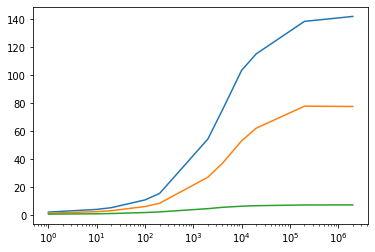

In [9]:
plt.semilogx(dilution,res_int[0,:]/flux_int[0,:])
plt.semilogx(dilution,res_int[1,:]/flux_int[1,:])
plt.semilogx(dilution,res_int[2,:]/flux_int[2,:])

## Resonance Integral as a function of dilution

In [10]:
norm = np.log(7000/6000) / flux_int[4,-1]  #normalize flux to 1/E, probably not best way to normalize ...

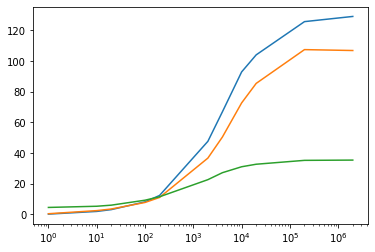

In [11]:
#plt.semilogx(dilution,res_int[0,:]*1/tmp_flux[0])
#plt.semilogx(dilution,res_int[1,:]*1/tmp_flux[0])
#plt.semilogx(dilution,res_int[2,:]*1/tmp_flux[0])
plt.semilogx(dilution,res_int[0,:]*norm)
plt.semilogx(dilution,res_int[1,:]*norm)
plt.semilogx(dilution,res_int[2,:]*norm)

RI_H1 = res_int[0,:]*norm
RI_H2 = res_int[1,:]*norm
RI_H3 = res_int[2,:]*norm
dilution_H = dilution

We can see that the microscopic cross-sections or RI vary significantly with the ratio of scatterer to resonant nuclide. We typically compute these curves/tables for H-1 for the absorption and scattering reactions at various temperatures.

What now remains is:
- How do we lookup these homogeneous tables?
- What happens when the scattering nuclide is not H1?

## Other nuclides

Let's assume the U-238 nucleus is mixed with O-16 instead of H-1.

In [12]:
N_u = 1 
N_h = 0
N_dil = np.array([10, 100, 1000,10000,100000,1000000])
#N_dil = np.array([100.0])
res_int = np.zeros([5,len(N_dil)])
flux_int = np.zeros([5,len(N_dil)])
dilution = np.zeros(len(N_dil))
for j in range(len(N_dil)):
    dilution[j] = I_xs*N_dil[j]/N_u
    tmp_flux = MC_slowing_down(N_h,N_u,N_dil[j],10000.0,100000)
    for i in range(len(energies)):
        u238_abs = abso.xs['294K'](energies[i])
        if energies[i] <10.0 and energies[i] >4.0:
            res_int[0,j] = res_int[0,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[0,j] = flux_int[0,j] + delta_e*tmp_flux[i]
            #print(u238_abs, delta_e*tmp_flux[i]*u238_abs,delta_e*tmp_flux[i] )
        elif energies[i] <40.0 and energies[i]>10.0:
            res_int[1,j] = res_int[1,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[1,j] = flux_int[1,j] + delta_e*tmp_flux[i]
        elif energies[i] <5530.0 and energies[i]>40.0:
            res_int[2,j] = res_int[2,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[2,j] = flux_int[2,j] + delta_e*tmp_flux[i]
        elif energies[i] <6000.0 and energies[i]>5530.0:
            res_int[3,j] = res_int[3,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[3,j] = flux_int[3,j] + delta_e*tmp_flux[i]
        elif energies[i] <7000.0 and energies[i]>6000.0:
            res_int[4,j] = res_int[4,j] + delta_e*tmp_flux[i]*u238_abs
            flux_int[4,j] = flux_int[4,j] + delta_e*tmp_flux[i]

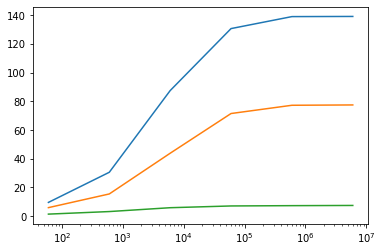

In [13]:
plt.semilogx(dilution,res_int[0,:]/flux_int[0,:])
plt.semilogx(dilution,res_int[1,:]/flux_int[1,:])
plt.semilogx(dilution,res_int[2,:]/flux_int[2,:])

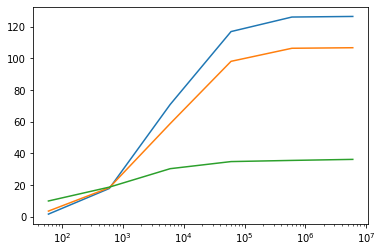

In [14]:
norm = np.log(7000/6000) / flux_int[4,-1]  #normalize flux to 1/E, probably not best way to normalize ...
plt.semilogx(dilution,res_int[0,:]*norm)
plt.semilogx(dilution,res_int[1,:]*norm)
plt.semilogx(dilution,res_int[2,:]*norm)

RI_O1 = res_int[0,:]*norm
RI_O2 = res_int[1,:]*norm
RI_O3 = res_int[2,:]*norm
dilution_O = dilution

Since in this case O-16 is not as good a moderator as H-1, we have 2 choices:
- Generate tables for each resonant nuclide as a function of all other nuclides
- Generate tables only for H-1 and measure how effective each other nuclide is compared to H-1

Clearly the first option would be incredibly costly, we thus use the intermediate resonance model.  This requires generating a table of factors that are energy dependent, dilution dependent and mass dependent.

If we compare the RI curve for H-1 and O-16, you see that the O-16 curve is essentially shifted.  Both curves have the same end points (because flux is normalized), but will differ in the transition.  If you use a scatterer with a larger mass, you will see a larger shift between the curves

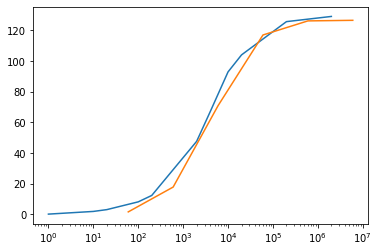

In [28]:
plt.semilogx(dilution_H,RI_H1)
plt.semilogx(dilution_O,RI_O1)

For LWRs, we typically do not compare 100% O-16 to 100% H-1 since there will always be a significant amount of H-1 in the system.  We typically do a comparison between a mixture of 1) 60b of H-1, 2) 30b of H-1 and 30b of O-16, and 3) 30b of H-1.  By comparing the RIs for these three cases, we can compute the IR correction factor.

## Resonance Interference

Lets now assume a mixture of U238, H-1 and Hf-177.  As you may remember, Hf-177 also has a very large resonance in the 6-7eV range that will interfere with U-238.

In [15]:
N_u = 1 
N_I = 0
N_H = 100
res_int = np.zeros(5)
flux_int = np.zeros(5)

tmp_flux = MC_slowing_down(N_H,N_u,N_I,2000000,100000)
for i in range(len(energies)):
    u238_abs = abso.xs['294K'](energies[i])
    if energies[i] <10.0 and energies[i] >4.0:
        res_int[0] = res_int[0] + delta_e*tmp_flux[i]*u238_abs
        flux_int[0] = flux_int[0] + delta_e*tmp_flux[i]
    elif energies[i] <40.0 and energies[i]>10.0:
        res_int[1] = res_int[1] + delta_e*tmp_flux[i]*u238_abs
        flux_int[1] = flux_int[1] + delta_e*tmp_flux[i]
    elif energies[i] <5530.0 and energies[i]>40.0:
        res_int[2] = res_int[2] + delta_e*tmp_flux[i]*u238_abs
        flux_int[2] = flux_int[2] + delta_e*tmp_flux[i]
    elif energies[i] <6000.0 and energies[i]>5530.0:
        res_int[3] = res_int[3] + delta_e*tmp_flux[i]*u238_abs
        flux_int[3] = flux_int[3] + delta_e*tmp_flux[i]
    elif energies[i] <7000.0 and energies[i]>6000.0:
        res_int[4] = res_int[4] + delta_e*tmp_flux[i]*u238_abs
        flux_int[4] = flux_int[4] + delta_e*tmp_flux[i]
        
print(res_int/flux_int)

[54.3312535  27.01480209  4.53080787  0.92229349  0.83968623]


In [16]:
hf177 = openmc.data.IncidentNeutron.from_hdf5('Hf177.h5')

In [17]:
abso_hf = hf177[102]
scat_hf = hf177[2]

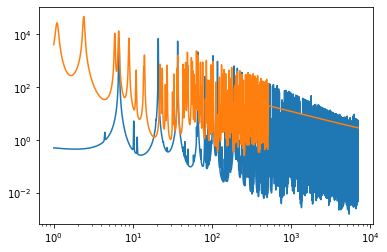

In [18]:
plt.loglog(energies,abso.xs['294K'](energies))
plt.loglog(energies,abso_hf.xs['294K'](energies))

In [19]:
A_I = 177
alpha_I = (A_I-1)**2/(A_I+1)**2

In [20]:
def MC_slowing_down2(N_h,N_u,N_I,Estart,nps):
    random.seed(a=2)
    abs_counter = np.zeros(5)
    flux_counter = np.zeros(len(energies))
    total_flux = 0
    for i in range(nps):
        E = Estart
        while (E>1.0):
            #Calculate Sigma_t, the next two lines read the abs and scat xs of U-238 at energy E, 
            #linear interpolation is performed automatically between the nearest values in the library.
            u238_abs = abso.xs['294K'](E)
            u238_scat = scat.xs['294K'](E)
            hf177_abs = abso_hf.xs['294K'](E)
            hf177_scat = scat_hf.xs['294K'](E)            
            sigt_u238 = u238_abs + u238_scat
            sigt_hf177 = hf177_abs + hf177_scat
            if E>6000.0:
                Sigma_t = N_h*h_xs 
            else:
                Sigma_t = N_h*h_xs + N_u*sigt_u238 + N_I*sigt_hf177
            if E<7000.0:
                index = math.floor((E-1.0)/delta_e)
                flux_counter[index] = flux_counter[index] + 1/Sigma_t
            # Sample which nuclide we are colliding with
            rng1 = random.random()
            if rng1<(N_h*h_xs / Sigma_t):
                Eprime = E*random.random()
            elif rng1<((N_h*h_xs+N_I*sigt_hf177) / Sigma_t) and rng1>((N_h*h_xs) / Sigma_t) :
                if random.random()<(hf177_abs/sigt_hf177):
                    Eprime = 0.0
                else:
                    Eprime = (E-alpha_I*E)*random.random()+alpha_I*E
            else:
                if random.random()<(u238_abs/sigt_u238):
                    if E>4.0 and E<10.0:
                        abs_counter[0] = abs_counter[0] + 1
                    elif E>10.0 and E<40.0:
                        abs_counter[1] = abs_counter[1] + 1
                    elif E>40.0 and E<5530.0:
                        abs_counter[2] = abs_counter[2] + 1
                    elif E>5530.0 and E<6000.0:
                        abs_counter[3] = abs_counter[3] + 1
                    elif E>6000.0 and E<7000.0:
                        abs_counter[4] = abs_counter[4] + 1
                    Eprime = 0.0
                else:
                    Eprime = (E-alpha_U*E)*random.random()+alpha_U*E
            E = Eprime
    #print(total_flux/nps)
    #print(flux_counter,sum(flux_counter))
    flux_counter = flux_counter/nps
    flux_counter = flux_counter/sum(flux_counter)
    return flux_counter

In [21]:
N_u = 1 
N_I = np.array([0.0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0])
N_H = 100

for j in range(len(N_I)):
    res_int = np.zeros(5)
    flux_int = np.zeros(5)
    tmp_flux = MC_slowing_down2(N_H,N_u,N_I[j],2000000,100000)
    for i in range(len(energies)):
        u238_abs = abso.xs['294K'](energies[i])
        if energies[i] <10.0 and energies[i] >4.0:
            res_int[0] = res_int[0] + delta_e*tmp_flux[i]*u238_abs
            flux_int[0] = flux_int[0] + delta_e*tmp_flux[i]
        elif energies[i] <40.0 and energies[i]>10.0:
            res_int[1] = res_int[1] + delta_e*tmp_flux[i]*u238_abs
            flux_int[1] = flux_int[1] + delta_e*tmp_flux[i]
        elif energies[i] <5530.0 and energies[i]>40.0:
            res_int[2] = res_int[2] + delta_e*tmp_flux[i]*u238_abs
            flux_int[2] = flux_int[2] + delta_e*tmp_flux[i]
        elif energies[i] <6000.0 and energies[i]>5530.0:
            res_int[3] = res_int[3] + delta_e*tmp_flux[i]*u238_abs
            flux_int[3] = flux_int[3] + delta_e*tmp_flux[i]
        elif energies[i] <7000.0 and energies[i]>6000.0:
            res_int[4] = res_int[4] + delta_e*tmp_flux[i]*u238_abs
            flux_int[4] = flux_int[4] + delta_e*tmp_flux[i]
    print(N_I[j],res_int/flux_int)

0.0 [54.3312535  27.01480209  4.53080787  0.92229349  0.83968623]
0.01 [54.12730656 26.90046635  4.57649733  0.92576995  0.83977361]
0.05 [52.8523202  27.64121408  4.63011569  0.92157732  0.83089208]
0.1 [49.95984451 27.29505091  4.64619501  0.9122759   0.82749873]
0.2 [46.86105164 26.42504021  4.5923166   0.92238868  0.82650977]
0.5 [41.50355274 26.68337333  4.60408045  0.91285742  0.81923503]
1.0 [35.38308868 26.75689829  4.67829072  0.92344348  0.82156413]


We can clearly see the impact of Hf-177 in the 6-10eV group cross-section and the negligible impact it has on the other groups.  So we could build a correction factor that captures the impact the necessary correction from having Hf-177 mixed with U-238.  Typically instead of doing this on a group-by-group and nuclide-by-nuclide basis, we do it as a function of burnup.

For LWRs, we often build our tables with U-238 always present.  This way the resonnance interferences with U238 are always captured accurately.  This works for LWRs since U-238 is the largest component in fuel and remains fairly constant throughout the lifetime of the assembly.